# FE621 Final Exam

Student: Yuxuan Xia

Supervisor: Ionut Florescu

Date: Aug/12/2018

## Problem A: Asian Option Pricing using Monte Carlo Control Variate.

In [1]:
import math
import numpy as np
import scipy as sp
import scipy.stats
import timeit

In [2]:
r = 0.03
sigma = 0.3
S = 100
K = 100
T = 5
n_days = T*252
n_trials = 10000

### (a) Price the geometric Asian option in Black-Scholes model using the theoretical formula

In [3]:
def geometricAsianCallOption(S,K,T,r,sigma,N):
    sigmaG = sigma*np.sqrt((2*N+1)/(6*(N+1)))
    rho = .5*(r-sigma**2/2+sigmaG**2)
    d1 = (np.log(S/K)+ (rho + .5*sigmaG**2)*T)/(np.sqrt(T)*sigmaG)
    d2 = (np.log(S/K)+ (rho - .5*sigmaG**2)*T)/(np.sqrt(T)*sigmaG)
    price = np.exp(-r*T)*(S*np.exp(rho*T)*sp.stats.norm.cdf(d1) - K*sp.stats.norm.cdf(d2))
    return price

In [4]:
geometric_call_price_formula = geometricAsianCallOption(S=S,K=K,T=T,r=r,sigma=sigma,N=n_days)
geometric_call_price_formula

15.171129680587903

### (b) Implement a Monte Carlo scheme to price an arithmetic Asian call option ($P_A^{sim}$). Use M = 1,000,000 simulations. Record the answer, the confidence interval and the time it takes to obtain the result.

I used the following engine made by myself last time in this assignment. The implementation is time-effective since it uses parellal computation technique. Moreover, it equipts Heston model and several boundary schemes which demonstrats itself a good pricing engine. But in order to make the most use of this engine, I set M=10,000 as denoted in question (d) to avoid insufficient memory.

In [5]:
class MonteCarloEngine:
    def __init__(self, S0=100, T=1, r=0, q=0, sigma=0, kappa=0, theta=0, theta1=0, xi=0, rho=0, V0=0,
                 underlying_process="geometric brownian motion"):
        self.underlying_process = underlying_process
        self.S0 = S0
        self.T = T
        self.r = r
        self.q = q
        self.sigma = sigma
        self.kappa = kappa
        self.theta = theta
        self.theta1 = theta1
        self.rho = rho
        self.V0 = V0
        self.xi = xi

        self.value_results = None

    # view antithetic variates as a option of simulation method to reduce the variance    
    def simulate(self, n_trials, n_steps, antitheticVariates=False, boundaryScheme="Higham and Mao"):

        dt = self.T / n_steps
        mu = self.r - self.q
        self.n_trials = n_trials
        self.n_steps = n_steps
        self.boundaryScheme = boundaryScheme

        if (self.underlying_process == "geometric brownian motion"):
            #             first_step_prices = np.ones((n_trials,1))*np.log(self.S0)
            log_price_matrix = np.zeros((n_trials, n_steps))
            normal_matrix = np.random.normal(size=(n_trials, n_steps))
            if (antitheticVariates == True):
                n_trials *= 2
                self.n_trials = n_trials
                normal_matrix = np.concatenate((normal_matrix, -normal_matrix), axis=0)
            cumsum_normal_matrix = normal_matrix.cumsum(axis=1)
            #             log_price_matrix = np.concatenate((first_step_prices,log_price_matrix),axis=1)
            deviation_matrix = cumsum_normal_matrix * self.sigma * np.sqrt(dt) + \
                               (mu - self.sigma ** 2 / 2) * dt * np.arange(1, n_steps + 1)
            log_price_matrix = deviation_matrix + np.log(self.S0)
            price_matrix = np.exp(log_price_matrix)
            price_zero = (np.ones(n_trials) * self.S0)[:, np.newaxis]
            price_matrix = np.concatenate((price_zero, price_matrix), axis=1)
            self.price_matrix = price_matrix

        elif (self.underlying_process == "CIR model"):
            # generate correlated random variables
            randn_matrix_v = np.random.normal(size=(n_trials, n_steps))
            if (antitheticVariates == True):
                n_trials *= 2
                self.n_trials = n_trials
                randn_matrix_v = np.concatenate((randn_matrix_v, -randn_matrix_v), axis=0)

            # boundary scheme fuctions
            if (boundaryScheme == "absorption"):
                f1 = f2 = f3 = lambda x: np.maximum(x, 0)
            elif (boundaryScheme == "reflection"):
                f1 = f2 = f3 = np.absolute
            elif (boundaryScheme == "Higham and Mao"):
                f1 = f2 = lambda x: x
                f3 = np.absolute
            elif (boundaryScheme == "partial truncation"):
                f1 = f2 = lambda x: x
                f3 = lambda x: np.maximum(x, 0)
            elif (boundaryScheme == "full truncation"):
                f1 = lambda x: x
                f2 = f3 = lambda x: np.maximum(x, 0)

            # simulate CIR process
            V_matrix = np.zeros((n_trials, n_steps + 1))
            V_matrix[:, 0] = self.S0

            for j in range(self.n_steps):
                V_matrix[:, j + 1] = f1(V_matrix[:, j]) - self.kappa * dt * (
                            f2(V_matrix[:, j]) - self.theta - self.theta1 * dt * j) + \
                                     self.xi * np.sqrt(f3(V_matrix[:, j])) * np.sqrt(dt) * randn_matrix_v[:, j]
                V_matrix[:, j + 1] = f3(V_matrix[:, j + 1])

            price_matrix = V_matrix
            self.price_matrix = price_matrix


        elif (self.underlying_process == "Heston model"):
            # generate correlated random variables
            randn_matrix_1 = np.random.normal(size=(n_trials, n_steps))
            randn_matrix_2 = np.random.normal(size=(n_trials, n_steps))
            randn_matrix_v = randn_matrix_1
            randn_matrix_S = self.rho * randn_matrix_1 + np.sqrt(1 - self.rho ** 2) * randn_matrix_2
            if (antitheticVariates == True):
                n_trials *= 2
                self.n_trials = n_trials
                randn_matrix_v = np.concatenate((randn_matrix_v, +randn_matrix_v), axis=0)
                randn_matrix_S = np.concatenate((randn_matrix_S, -randn_matrix_S), axis=0)

            # boundary scheme fuctions
            if (boundaryScheme == "absorption"):
                f1 = f2 = f3 = lambda x: np.maximum(x, 0)
            elif (boundaryScheme == "reflection"):
                f1 = f2 = f3 = np.absolute
            elif (boundaryScheme == "Higham and Mao"):
                f1 = f2 = lambda x: x
                f3 = np.absolute
            elif (boundaryScheme == "partial truncation"):
                f1 = f2 = lambda x: x
                f3 = lambda x: np.maximum(x, 0)
            elif (boundaryScheme == "full truncation"):
                f1 = lambda x: x
                f2 = f3 = lambda x: np.maximum(x, 0)

            # simulate stochastic volatility process
            V_matrix = np.zeros((n_trials, n_steps + 1))
            V_matrix[:, 0] = self.V0
            log_price_matrix = np.zeros((n_trials, n_steps + 1))
            log_price_matrix[:, 0] = np.log(self.S0)
            for j in range(self.n_steps):
                #                 V_matrix[:,j+1] = self.kappa*self.theta*dt + (1-self.kappa*dt)*V_matrix[:,j] +\
                #                     self.xi*np.sqrt(V_matrix[:,j]*dt)*randn_matrix_v[:,j]
                V_matrix[:, j + 1] = f1(V_matrix[:, j]) - self.kappa * dt * (f2(V_matrix[:, j]) - self.theta) + \
                                     self.xi * np.sqrt(f3(V_matrix[:, j])) * np.sqrt(dt) * randn_matrix_v[:, j]
                V_matrix[:, j + 1] = f3(V_matrix[:, j + 1])
                log_price_matrix[:, j + 1] = log_price_matrix[:, j] + (mu - V_matrix[:, j] / 2) * dt + \
                                             np.sqrt(V_matrix[:, j] * dt) * randn_matrix_S[:, j]
            price_matrix = np.exp(log_price_matrix)
            self.price_matrix = price_matrix

        return price_matrix

In [6]:
def arithmaticAsianCallOptionFromMC(price_matrix,K):
    n_steps = price_matrix.shape[1]-1
    option_prices = np.maximum(price_matrix.mean(axis=1) - K,0)
    option_price_mean = option_prices.mean()
    option_price_std = np.std(option_prices)
    return option_price_mean,option_price_std

In [7]:
try:
    del price_matrix
except:
    pass

In [8]:
tik = timeit.default_timer()
mc_engine = MonteCarloEngine(S0=S,T=T,r=r,sigma=sigma, underlying_process="geometric brownian motion")
price_matrix = mc_engine.simulate(n_trials=n_trials,n_steps=n_days)
arithmetic_call_mean,arithmetic_call_std = arithmaticAsianCallOptionFromMC(price_matrix,K)
tok = timeit.default_timer()
geometricAsian_runtime = tok - tik
print("runtime: {}".format(geometricAsian_runtime))

runtime: 0.8923041549843576


Then, using central limit theorem, we can obtain the confidence interval for given level, say, 95% (z=1.96).

Recall the Central Limit Theorem:
$$ \frac{(\overline{x} -\mu)}{\sigma /\sqrt{n}} \sim N(0,1)$$

The interval can be expressed as:
$$\overline{x} \pm z \frac{\sigma}{\sqrt{n}}$$

In [9]:
CI95 = lambda call_mean, call_std: (call_mean - 1.96*call_std/np.sqrt(n_trials),call_mean + 1.96*call_std/np.sqrt(n_trials))

In [10]:
print("95% confidence interval: {}".format(CI95(arithmetic_call_mean,arithmetic_call_std)))

95% confidence interval: (20.106480460405692, 21.544457758007418)


In [11]:
print("mean value: {}".format(arithmetic_call_mean))

mean value: 20.825469109206555


### (c) Implement a Monte Carlo scheme to price a geometric Asian Call option ($P_A^{sim}$).

In [12]:
def geometricAsianCallOptionFromMC(price_matrix,K):
    n_steps = price_matrix.shape[1]-1
    log_price_matrix = np.log(price_matrix)
    option_prices = np.maximum(np.exp(log_price_matrix.mean(axis=1)) - K,0)
    option_price_mean = option_prices.mean()
    option_price_std = np.std(option_prices)
    return option_price_mean,option_price_std

In [13]:
try:
    del price_matrix
except:
    pass

In [14]:
tik = timeit.default_timer()
mc_engine = MonteCarloEngine(S0=S,T=T,r=r,sigma=sigma, underlying_process="geometric brownian motion")
price_matrix = mc_engine.simulate(n_trials=n_trials,n_steps=n_days)
geometric_call_mean,geometric_call_std = geometricAsianCallOptionFromMC(price_matrix,K)
tok = timeit.default_timer()
geometricAsian_runtime = tok - tik
print("runtime: {}".format(geometricAsian_runtime))

runtime: 1.0961924330636774


In [15]:
print("95% confidence interval: {}".format(CI95(geometric_call_mean,geometric_call_std)))

95% confidence interval: (17.205845404757682, 18.424965038414172)


In [16]:
print("mean value: {}".format(geometric_call_mean))

mean value: 17.815405221585927


### (d) Using M = 10,000 simulations and the same exact random variables, calculate the optimal coefficent b

Here we can directly use the result in (b) and (c) to comput the following questions

In [17]:
X = np.random.randn(1000)
Y = np.random.randn(1000)
Z = 0.3*X + np.sqrt(1-0.09)*Y
np.cov(X,Z)

array([[ 0.97311084,  0.27328676],
       [ 0.27328676,  0.97177672]])

In [18]:
def optimalB(price_matrix):
    arithmetic_call_prices = np.maximum(price_matrix.mean(axis=1) - K,0)
    geometric_call_prices = np.maximum(np.exp(np.log(price_matrix).mean(axis=1))-K,0)
    covariance_matrix = np.cov(arithmetic_call_prices,geometric_call_prices)
    b = covariance_matrix[0,1]/covariance_matrix[1,1]
    return b

In [19]:
b = optimalB(price_matrix)
b

1.1456219824504434

### (e) Calculate the error of pricing for the geometric Asian: $E_g = P_g - P_g^{sim}$

In [20]:
arithmetic_call_prices = np.maximum(price_matrix.mean(axis=1) - K,0)
geometric_call_prices = np.maximum(np.exp(np.log(price_matrix).mean(axis=1))-K,0)

In [21]:
geometric_call_price_MC = geometric_call_prices.mean()

In [22]:
Eg = geometric_call_price_formula - geometric_call_price_MC
Eg

-2.6442755409980236

### (f) Calculate the modified arithmetic option price

In [23]:
arithmetic_call_prices.mean() + b* Eg

17.440845980804333

In [24]:
try:
    del price_matrix
except:
    pass

In [25]:
def arithmeticAsianCallControlVariete(S,K,T,r,sigma,n_days,n_trials):
    mc_engine = MonteCarloEngine(S0=S,T=T,r=r,sigma=sigma, underlying_process="geometric brownian motion")
    price_matrix = mc_engine.simulate(n_trials=n_trials,n_steps=n_days)
    b = optimalB(price_matrix)
    arithmetic_call_prices = np.maximum(price_matrix.mean(axis=1) - K,0)
    geometric_call_prices = np.maximum(np.exp(np.log(price_matrix).mean(axis=1))-K,0)
    
    geometric_call_price_formula = geometricAsianCallOption(S=S,K=K,T=T,r=r,sigma=sigma,N=n_days)
    Eg = geometric_call_price_formula - geometric_call_prices.mean()
    
    unmodified_price = arithmetic_call_prices.mean()
    modified_price = unmodified_price + b* Eg
    return modified_price, unmodified_price

In [35]:
modified_prices = []
unmodified_prices = []
for i in [100,500,1000,5000,10000]:
    modified_price, unmodified_price = arithmeticAsianCallControlVariete(S=S,K=K,T=T,r=r,sigma=sigma,n_days=n_days,n_trials=i)
    modified_prices.append(modified_price)
    unmodified_prices.append(unmodified_price)

In [36]:
modified_prices

[18.027171967259097,
 17.567325652812237,
 17.504307446364532,
 17.508553006056253,
 17.479082510158598]

In [37]:
unmodified_prices

[20.433805195363544,
 20.008285131579449,
 20.900333116071181,
 20.615918737235841,
 20.051173389103838]

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

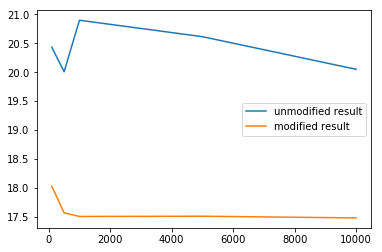

In [39]:
numberOfTrials = [100,500,1000,5000,10000]
plt.plot(numberOfTrials,unmodified_prices)
plt.plot(numberOfTrials,modified_prices)
plt.legend(["unmodified result","modified result"])

Conclusion: from the picture above, we can see the control variate method reduce the variance considerablly.

In [40]:
try:
    del price_matrix
except:
    pass